In [1]:
import sys; print(sys.version)
import os
import glob
import re
# import subprocess
# import multiprocessing
# import io
# from collections import OrderedDict

import numpy as np; print('numpy', np.__version__)
import pandas as pd; print('pandas',pd.__version__)
# import allel; print('scikit-allel', allel.__version__)
# import zarr; print('zarr', zarr.__version__)

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import ConnectionPatch

# import statsmodels; print('statsmodels', statsmodels.__version__)
# import statsmodels.api as sm

from IPython.display import display, HTML

3.6.7 | packaged by conda-forge | (default, Jul  2 2019, 02:18:42) 
[GCC 7.3.0]
numpy 1.17.0
pandas 0.25.0


In [2]:
# %matplotlib notebook
%matplotlib inline
mpl.rcParams['figure.facecolor'] = '#BBBBBB'


In [3]:

POP_DEFS = [
    ['Mali', '#4f94cd', 'Mali'],
    ['Cameroon', '#20b2aa', 'Cameroon'],
    ['Zambia', '#008b45', 'Zambia'],
    ['Tanzania', '#7ccd7c', 'Tanzania'],
    ['GrandeComore', '#ba55d3', 'Grande Comore'],
    ['Moheli', '#ee7600', 'Mohéli'],
    ['Anjouan', '#ee0000', 'Anjouan'],
]

# Island ages
ISLAND_AGES = [['Grande\nComore', 130000],
               ['Anjouan', 1200000],
               ['Mohéli', 2750000], 
              ]

### Convert the MSMC2 data into more easily/quickly read format
**Only needs to be done once**

In [4]:
if False:
    data = None
    for pop,_,_ in POP_DEFS:
        print(pop)
        fn = 'Ne_'+pop+'.txt.gz'
        d = pd.read_csv(fn, header=None, index_col=False, names=[pop], engine='c')
        if data is None:
            data = d
        else:
            data = data.join(d, how='outer')

#     display(data.head())
#     display(data.shape)
    
    # remove duplicates to reduce data size
    data = data.fillna(-1)
    data = data.loc[(data.diff()!=0).any(axis=1),:]
    data = data.replace(-1, np.nan)
    
    data.to_hdf("msmc2_Ne_data.hdf", key='Ne')
    display(data.head())
    display(data.shape)

In [5]:
if False:
    rcc_pop_pairs = []
    for rccfile in glob.glob('RCC_*_vs_*.txt.gz'):
        print(rccfile)
        res = re.match(r'RCC_(.*)_vs_(.*).txt.gz', rccfile)
        assert len(res.groups()) == 2
        rcc_pop_pairs.append(res.groups())
    print(rcc_pop_pairs)

    data = None
    for pop1,pop2 in rcc_pop_pairs:
        print(pop1,pop2)
        fn = 'RCC_'+pop1+'_vs_'+pop2+'.txt.gz'
        d = pd.read_csv(fn, header=None, index_col=False, names=[pop1+' vs '+pop2], engine='c')
        if data is None:
            data = d
        else:
            data = data.join(d, how='outer')

    # remove duplicates to reduce data size
    data = data.fillna(-1)
    data = data.loc[(data.diff()!=0).any(axis=1),:]
    data = data.replace(-1, np.nan)
    
    data.to_hdf("msmc2_RCC_data.hdf", key='RCC')
    display(data.head())
    display(data.shape)

# Actual figure...

In [6]:
d = pd.read_hdf("msmc2_Ne_data.hdf", key='Ne')
d2 = pd.read_hdf("msmc2_RCC_data.hdf", key='RCC')

/home/travc/miniconda3/envs/allel/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


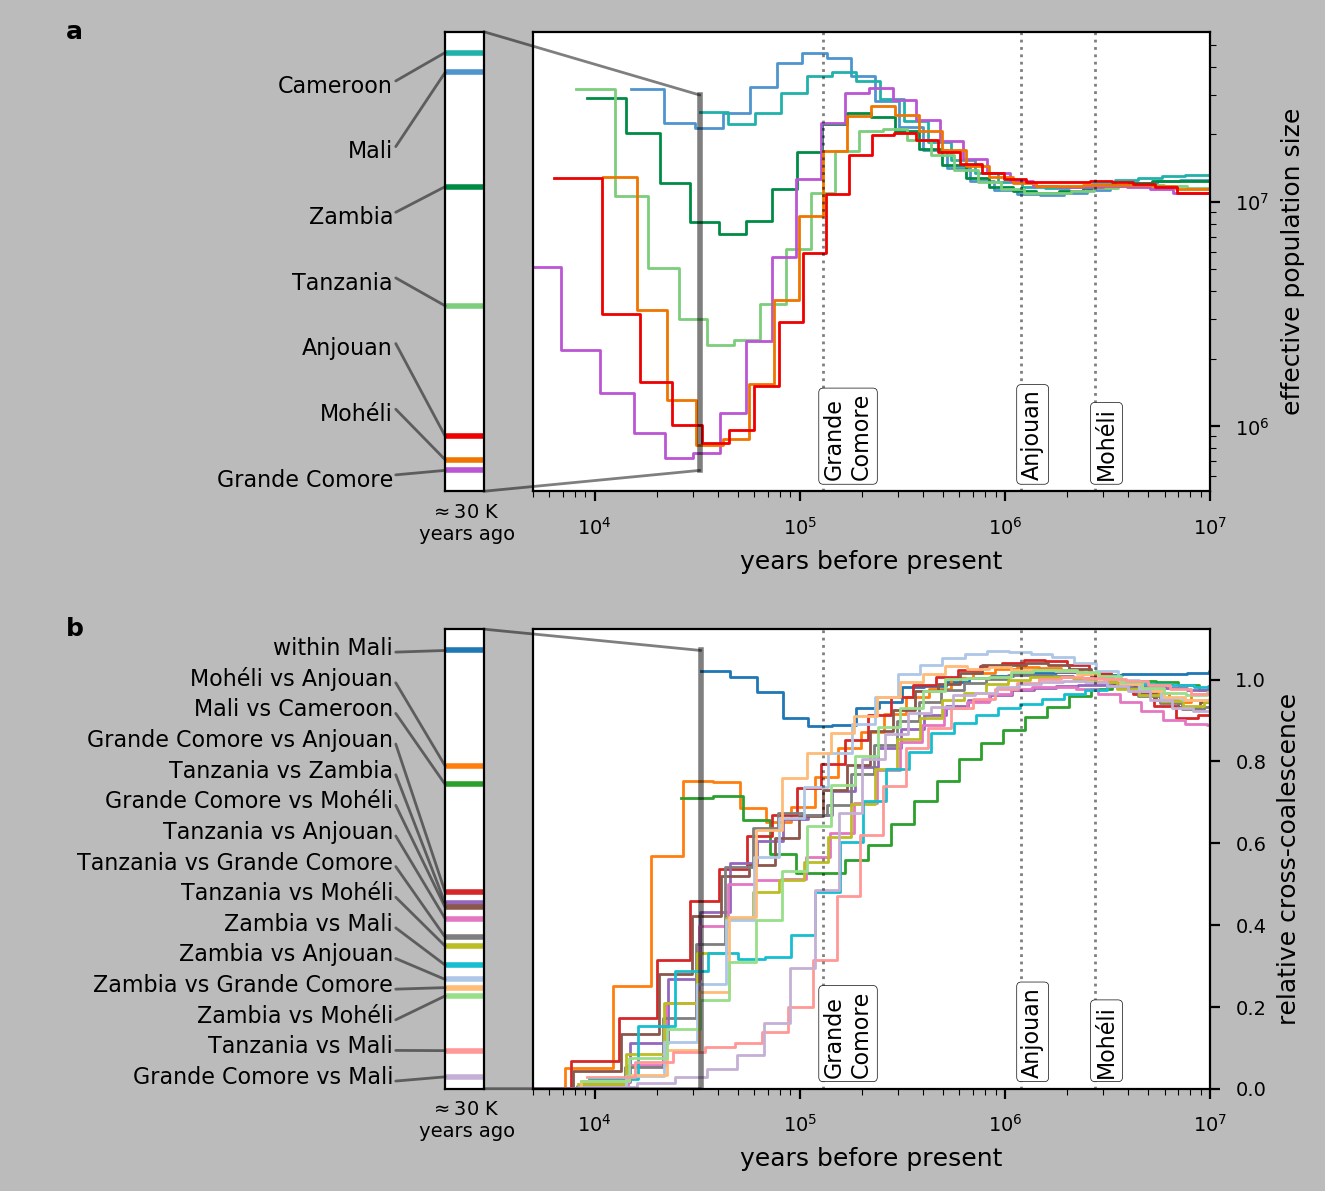

In [7]:
with plt.style.context('seaborn-paper'):
    mpl.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
    mpl.rcParams['xtick.labelsize'] = 7
    mpl.rcParams['ytick.labelsize'] = 7
    mpl.rcParams['axes.labelsize'] = 9
    
    fig = mpl.pyplot.figure(figsize=[7,7], dpi=200)
    gs = mpl.gridspec.GridSpec(2, 3, width_ratios=[14, 2, 35])
    
    #######################################
    ## Effective pop size
    axs = np.array([[plt.subplot(gs[0,0]),plt.subplot(gs[0,1]),plt.subplot(gs[0,2])]])
#     ax = plt.subplot(gs[0,:])
    ax = axs[0,2]
    ax0 = ax # save for adding annotation below
    for pop,color,lab in POP_DEFS:
        ax.step(d.index.values, d[pop].values, where='post', color=color, label=lab, lw=1)
    ax.set_xscale('log')
    ax.set_yscale('log')

    trans = mpl.transforms.blended_transform_factory(ax.transData, ax.transAxes)
    for name,v in ISLAND_AGES:
        ax.axvline(v, c='k', ls=':', lw=1, alpha=0.5)
        ax.annotate(name, xy=(v, .025), fontsize=8,
                    xycoords=("data", "axes fraction"), 
                    ha='left', va='bottom', rotation=90,
                    bbox={'boxstyle':"round",'pad':0.2,'fc':"w"})

    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_xlabel("years before present")
#     ax.set_ylabel(r"$\mathrm{N_e}$")
    ax.set_ylabel("effective population size")
#     ax.legend(fontsize=8, edgecolor='black', loc='lower right')#handlelength=1, borderaxespad=.2)
    # hardcode common x limits
    ax.set_xlim((5e3, 1e7))
    
    # zoom
    ax = axs[0,1]
    first_idx = d.sum(skipna=False, axis=1).first_valid_index()
#     tmpd = d.sort_values(first_idx, axis=1, ascending=False)
    t = d.loc[first_idx].sort_values(ascending=False)
    for li,(pop, val) in enumerate(t.items()):
        _,color1,lab1 = [x for x in POP_DEFS if x[0] == pop][0]
        ax.plot([first_idx-1,first_idx], [val, val],
                label=pop, linestyle='-', lw=2,
                c=color1)
        
#     axs[0,2].get_shared_y_axes().join(axs[0,2], axs[0,1])
    ax.set_yscale('log')
    ax.set_xlim((first_idx-1,first_idx))
    ax.set_ylim(bottom=0)
    ax.annotate(r"$\approx$"+"30 K\n years ago", xy=(first_idx-.5, -.025), 
                    xycoords=("data", "axes fraction"), 
                    ha='center', va='top', fontsize=7)
    # callout and shaded line on main subplot indicating location of zoom
    axs[0,1].set_zorder(1)
    ylim = ax.get_ylim()
    axs[0,2].plot([first_idx,first_idx], ylim, c='k', ls='-', lw=2, alpha=.5)       
    con = ConnectionPatch(xyA=(first_idx, ylim[0]), xyB=(first_idx, ylim[0]),
                          coordsA="data", coordsB="data",
                          axesA=axs[0,1], axesB=axs[0,2],
                          linewidth=1, color='k', alpha=.5)
    axs[0,1].add_artist(con)
    con = ConnectionPatch(xyA=(first_idx, ylim[1]), xyB=(first_idx, ylim[1]),
                          coordsA="data", coordsB="data",
                          axesA=axs[0,1], axesB=axs[0,2],
                          linewidth=1, color='k', alpha=.5)
    axs[0,1].add_artist(con)
    
    ax.yaxis.tick_right()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    ## Legend
    ax = axs[0,0]
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    [_.set_visible(False) for _ in ax.spines.values()]
    ax.patch.set_visible(False)
#     ax.legend(h,l,fontsize=9)
    ax.set_ylim((-1, t.shape[0]-1))
    ax.invert_yaxis()
    ax.set_zorder(2)    
    for i,(pop,v) in enumerate(t.items()):
        _,color1,lab1 = [x for x in POP_DEFS if x[0] == pop][0]
        ax.text(.99,i, lab1, 
                ha='right', va='bottom', fontsize=8)
        con = ConnectionPatch(xyA=(1, i-0.25), xyB=(first_idx-1, v),
                      coordsA="data", coordsB="data",
                      axesA=ax, axesB=axs[0,1],
                      linewidth=1, color='k', alpha=.5)
        ax.add_artist(con)


    ###############################################
    ## Cross-coalesence   
    axs = np.array([[plt.subplot(gs[1,0]),plt.subplot(gs[1,1]),plt.subplot(gs[1,2])]])
    plt.set_cmap('tab20')
    colors = plt.get_cmap('tab20').colors
    colors = colors[0:20:2]+colors[1:20:2]
    
    first_idx = d2.sum(skipna=False, axis=1).first_valid_index()
    d2 = d2.sort_values(first_idx, axis=1, ascending=False)
    
    ax = axs[0,2]
    for li,lab in enumerate(d2.columns):
        pop1,pop2 = lab.split(' vs ')
        _,color1,lab1 = [x for x in POP_DEFS if x[0] == pop1][0]
        _,color2,lab2 = [x for x in POP_DEFS if x[0] == pop2][0]
        ax.step(d2.index.values, d2[lab].values, where='post', label=lab1+' vs '+lab2, linestyle='-', lw=1,
                c=colors[li])
    ax.set_xscale('log')
#     ax.set_yscale('log')
    ax.set_ylim(bottom=0)
    # hardcode common x limits
    ax.set_xlim((5e3, 1e7))
    
    trans = mpl.transforms.blended_transform_factory(ax.transData, ax.transAxes)
    for name,v in ISLAND_AGES:
        ax.axvline(v, c='k', ls=':', lw=1, alpha=0.5)
        ax.annotate(name, xy=(v, .025), 
                    xycoords=("data", "axes fraction"), fontsize=8, 
                    ha='left', va='bottom', rotation=90,
                    bbox={'boxstyle':"round",'pad':0.2,'fc':"w"})

    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.set_xlabel("years before present")
    ax.set_ylabel("relative cross-coalescence")
        
    # zoom
    ax = axs[0,1]
    t = d2.loc[first_idx].sort_values(ascending=False)
    for li,lab in enumerate(d2.columns):
        pop1,pop2 = lab.split(' vs ')
        _,color1,lab1 = [x for x in POP_DEFS if x[0] == pop1][0]
        _,color2,lab2 = [x for x in POP_DEFS if x[0] == pop2][0]
        ax.plot([first_idx-1,first_idx], [t[lab], t[lab]],
                label=lab1+' vs '+lab2, linestyle='-', lw=2,
                c=colors[li])
#     ax.set_yscale('log')
    ax.set_xlim((first_idx-1,first_idx))
    ax.set_ylim(bottom=0)
    ax.annotate(r"$\approx$"+"30 K\n years ago", xy=(first_idx-.5, -.025), 
                    xycoords=("data", "axes fraction"), 
                    ha='center', va='top', fontsize=7)
    
    # callout and shaded line on main subplot indicating location of zoom
    axs[0,1].set_zorder(1)
    ylim = ax.get_ylim()
    axs[0,2].plot([first_idx,first_idx], ylim, c='k', ls='-', lw=2, alpha=.5)       
    con = ConnectionPatch(xyA=(first_idx, ylim[0]), xyB=(first_idx, ylim[0]),
                          coordsA="data", coordsB="data",
                          axesA=axs[0,1], axesB=axs[0,2],
                          linewidth=1, color='k', alpha=.5)
    axs[0,1].add_artist(con)
    con = ConnectionPatch(xyA=(first_idx, ylim[1]), xyB=(first_idx, ylim[1]),
                          coordsA="data", coordsB="data",
                          axesA=axs[0,1], axesB=axs[0,2],
                          linewidth=1, color='k', alpha=.5)
    axs[0,1].add_artist(con)
    
    ax.yaxis.tick_right()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
#     [_.set_visible(False) for _ in ax.spines.values()]
#     ax.patch.set_visible(False)
#     ax.legend(h,l,fontsize=9)

    ## Legend
    ax = axs[0,0]
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    [_.set_visible(False) for _ in ax.spines.values()]
    ax.patch.set_visible(False)
#     ax.legend(h,l,fontsize=9)
    ax.set_ylim((-1, t.shape[0]-1))
    ax.invert_yaxis()
    ax.set_zorder(2)    
    for i,(k,v) in enumerate(t.items()):
        pop1,pop2 = k.split(' vs ')
        _,color1,lab1 = [x for x in POP_DEFS if x[0] == pop1][0]
        _,color2,lab2 = [x for x in POP_DEFS if x[0] == pop2][0]
        s = lab1+' vs '+lab2
        if lab1 == lab2:
            s = 'within '+lab1
        ax.text(.99,i, s, 
                ha='right', va='bottom', fontsize=8)
        con = ConnectionPatch(xyA=(1, i-0.25), xyB=(first_idx-1, v),
                      coordsA="data", coordsB="data",
                      axesA=ax, axesB=axs[0,1],
                      linewidth=1, color='k', alpha=.5)
        ax.add_artist(con)

    ax0.annotate("a", xy=(.05,1), xycoords=("figure fraction", "axes fraction"), 
                    ha='left', va='center', fontsize=9, fontweight='bold')
    axs[0,0].annotate("b", xy=(.05,1), xycoords=("figure fraction", "axes fraction"), 
                    ha='left', va='center', fontsize=9, fontweight='bold')  

    
    fig.subplots_adjust(wspace=0.15, hspace=.3)
#     fig.tight_layout(pad=0, w_pad=0,h_pad=0.0)
    fig.savefig('combined_fig.svg', bbox_inches='tight')